In [12]:
import os
import numpy as np


# return ksi, omegas, omega_d, freqs
def calFreqs(evals, beta, alpha):
    num_modes = len(evals)
    valid_map = np.zeros(num_modes)
    omegas = np.zeros(num_modes)
    omega_d = np.zeros(num_modes)
    ksi = np.zeros(num_modes)
    freqs = np.zeros(num_modes)

    for i in range(num_modes):
        if (evals[i] < 0):
            valid_map[i] = 0
            print('evals < 0 at ', i)
            continue

        omegas[i] = np.sqrt(evals[i])

        if (omegas[i] < 100 or omegas[i] > 2e5):
            print(f'omegas[{i}] = {omegas[i]} is out of 20hz 20000hz range')
            valid_map[i] = 0
            continue
        
        ksi[i] = (beta + alpha * evals[i]) / 2 / omegas[i]
        scale = 1 - ksi[i] * ksi[i]
        if (scale < 0 ):
            valid_map[i] = 0
            print('1 - ksi^2 < 0 at', i)
            continue

        omega_d[i] = omegas[i] * np.sqrt(scale)
        freqs[i] = 0.5 * omega_d[i] / np.pi
    return ksi, omegas, omega_d, freqs

# return mode_sample, samples
def genSound(ksi, omegas, omega_d, scales, fs, duration):
    num_modes = len(ksi)

    time_slot = np.arange(fs * duration) / fs

    mode_sample = np.zeros((num_modes, len(time_slot)))
    samples = np.zeros(len(time_slot))

    for i in range(num_modes):
        if(omega_d[i] != 0):
            amplitude = np.exp(time_slot * (-1) * ksi[i] * omegas[i]) * abs(scales[i]) / omega_d[i]
            mode_sample[i] = (np.sin(omega_d[i] * time_slot ) * amplitude).astype(np.float32)
            samples += mode_sample[i]
    return mode_sample, samples

def saveSound(filename, fs, samples):
    from scipy.io.wavfile import write
    tmp_samples = samples * 1e6
    write(filename, fs, tmp_samples)

In [21]:
###### Load #####
filename = 'T' + '150'
# obj_dir = '../DATA/obj/test'
gt_dir = '../DATA/eigen'
pred_dir = '../DATA/test_results'

# obj_file = os.path.join(obj_dir, filename+'.obj')
gt_file = os.path.join(gt_dir, filename, 'eigen.npz')
pred_file = os.path.join(pred_dir, filename+'.npy')

gt_read = np.load(gt_file)
gt = gt_read['evals']
evecs = gt_read['evecs']
pred = np.load(pred_file)
pred = pred * 1e9

In [22]:
gt

array([2.77270423e-07, 3.08779589e-07, 6.04673655e-07, 1.01796091e+08,
       1.02256900e+08, 1.20542183e+08, 1.50786518e+08, 1.57545647e+08,
       1.69095906e+08, 1.74934536e+08, 1.82887961e+08, 1.94194548e+08,
       1.99442221e+08, 2.06463382e+08, 2.20355984e+08, 2.39297608e+08,
       2.46709645e+08, 2.60106453e+08, 3.57675616e+08, 3.67474540e+08,
       3.82717402e+08, 6.30584861e+08, 6.33712903e+08, 7.00295359e+08,
       7.64963805e+08, 7.83296751e+08, 9.11759142e+08, 1.02631664e+09,
       1.04760981e+09, 1.06213293e+09, 1.07061276e+09, 1.12415769e+09,
       1.17084191e+09, 1.20656914e+09, 1.26812151e+09, 1.33222807e+09,
       1.40565478e+09, 1.48934108e+09, 1.51659038e+09, 1.54913079e+09,
       1.59211577e+09, 1.69061335e+09, 1.84115381e+09, 1.87841304e+09,
       1.93075648e+09, 1.98223586e+09, 2.07322656e+09, 2.13665184e+09,
       2.21445166e+09, 2.31139108e+09])

In [23]:
pred

array([-1.11790984e+05,  7.18412891e+04, -6.92775500e+05,  8.56108400e+07,
        8.88298080e+07,  9.89273280e+07,  1.33951504e+08,  1.40725888e+08,
        1.52406928e+08,  2.08882752e+08,  2.19002928e+08,  2.33517440e+08,
        2.61161120e+08,  2.73239200e+08,  2.89868448e+08,  3.26664672e+08,
        3.41445120e+08,  3.74266688e+08,  4.60015520e+08,  4.80016576e+08,
        5.25566752e+08,  6.16252672e+08,  6.48533120e+08,  6.95567808e+08,
        8.05136768e+08,  8.44416064e+08,  9.06888000e+08,  1.00822662e+09,
        1.04789254e+09,  1.10412326e+09,  1.17635354e+09,  1.23406285e+09,
        1.29101274e+09,  1.36808358e+09,  1.41868659e+09,  1.49765837e+09,
        1.55691866e+09,  1.61526618e+09,  1.68541978e+09,  1.76408307e+09,
        1.80786509e+09,  1.86668646e+09,  1.93376166e+09,  2.00944922e+09,
        2.09374592e+09,  2.16536038e+09,  2.23421466e+09,  2.30857728e+09,
        2.39475149e+09,  2.47483802e+09], dtype=float32)

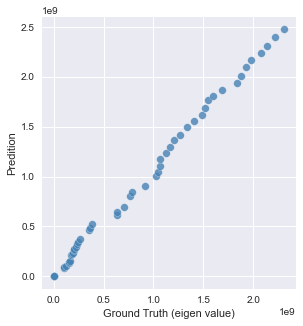

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(5,5))
# 绘图
plt.scatter(gt, # x轴数据为汽车速度
            pred, # y轴数据为汽车的刹车距离
            s = 60, # 设置点的大小 
            c = 'steelblue', # 设置点的颜色
            # marker = 's', # 设置点的形状
            alpha = 0.8, # 设置点的透明度
            linewidths = 0.3, # 设置散点边界的粗细、
            edgecolors = 'white' # 设置散点边界的颜色
            )

ax = plt.gca()
ax.set_aspect(1)
plt.xlabel('Ground Truth (eigen value)')
plt.ylabel('Predition')

plt.show()

In [25]:
###### Cal Freqs #####
pd_ksi, pd_omegas, pd_omega_d, pd_freqs = calFreqs(pred, beta=5.0, alpha=1e-7)
gt_ksi, gt_omegas, gt_omega_d, gt_freqs = calFreqs(gt, beta=5.0, alpha=1e-7)

evals < 0 at  0
evals < 0 at  2
omegas[0] = 0.0005265647375101811 is out of 20hz 20000hz range
omegas[1] = 0.0005556793941363074 is out of 20hz 20000hz range
omegas[2] = 0.0007776076483188212 is out of 20hz 20000hz range


In [26]:
###### Set Force #####
contact_pos = 196
contact_force = [0, 10, 0]
scales = np.zeros(50)
for dir in range(3):
    scales += contact_force[dir] * evecs[3*contact_pos + dir]


In [27]:
###### Save as file #####
duration = 3
fs = 44100
gt_mode_sample, gt_sample = genSound(gt_ksi, gt_omegas, gt_omega_d, scales, fs, duration)
pd_mode_sample, pd_sample = genSound(pd_ksi, pd_omegas, pd_omega_d, scales, fs, duration)

saveSound(os.path.join('./EXP/', filename+'_gt.wav'), fs, gt_sample)
saveSound(os.path.join('./EXP/', filename+'_test.wav'), fs, gt_sample)